In [4]:
from bs4 import BeautifulSoup
import json
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pymystem3 import Mystem
import pickle
import re
from nltk.corpus import stopwords
import nltk
import sqlite3

In [5]:
from sklearn.decomposition import LatentDirichletAllocation as LDA


In [2]:
pattern = re.compile("[^a-zA-Z0-9а-яА-ЯёЁ-]+")
stopwords_rus = stopwords.words('russian')
stemmer = Mystem()
def text_cleaner(text):
    clean_text = ' '.join(list(filter(None, [i.strip() for i in re.sub(pattern, ' ', text).lower().split(' ') if i not in stopwords_rus])))
    out = ' '.join([i for i in stemmer.lemmatize(clean_text) if i not in (' ', '\n')])
    return out

In [6]:
conn = sqlite3.connect('../diplom.db')
cur = conn.cursor()


In [7]:
df = pd.read_sql("SELECT * FROM GD_TEXTS0021 WHERE DEMOCRACY_COUNT > 0;", conn)

In [8]:
corpus = [text.split() for text in df.CLEAN_TEXT.to_list()]

In [12]:
lda = LDA(n_components=5, random_state=0)

In [17]:
def sovereign_democracy(text):
    return text.count("суверенный демократия")

In [63]:
df["SOVEREIGN"] = df["CLEAN_TEXT"].apply(sovereign_democracy)

In [64]:
df = df[df.DDATE>="2005-01-01"]
df["DDATE"] = pd.to_datetime(df.DDATE)
# sov = sov.set_index("DDATE")

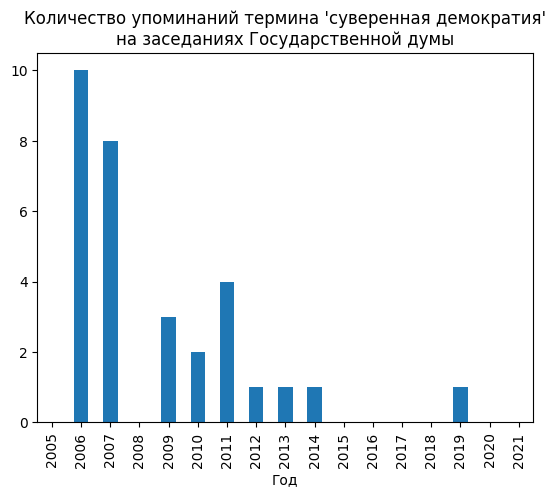

In [65]:
plot = df.groupby(df.DDATE.dt.year).SOVEREIGN.sum().plot(kind="bar")
plt.title("Количество упоминаний термина 'суверенная демократия'\nна заседаниях Государственной думы")
plt.xlabel("Год")
plt.savefig("Количество упоминаний термина 'суверенная демократия' на заседаниях Государственной думы.png")
plt.show()

In [66]:
sov = pd.read_csv("sovereignDemocracy.csv", header=1)

In [67]:
sov["Month"] = pd.to_datetime(sov["Month"])
sov = sov[(sov.Month>="2005")&(sov.Month<="2021")]

In [68]:
sov["Sovereign democracy: (Russia)"] = sov["Sovereign democracy: (Russia)"].replace("<1", 0).astype("int32")

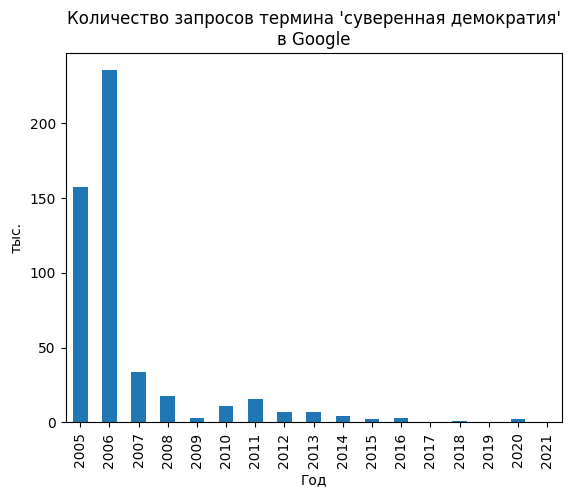

In [69]:
plot = sov.groupby(sov.Month.dt.year)["Sovereign democracy: (Russia)"].sum().plot(kind="bar")
plt.title("Количество запросов термина 'суверенная демократия'\nв Google")
plt.xlabel("Год")
plt.ylabel("тыс.")
plt.savefig("Количество запросов термина 'суверенная демократия' в Google.png")
plt.show()

In [21]:
for row in df[df["SOVEREIGN"]>0].iterrows():
    with open(f"sovereign/{row[1].DDATE}.txt", 'w') as f:
        f.write(row[1].TRANSCRIPT)

In [16]:
import gensim

ImportError: cannot import name 'Mapping' from 'collections' (C:\Program Files\Python312\Lib\collections\__init__.py)

In [17]:
!pip install --upgrade gensim

Defaulting to user installation because normal site-packages is not writeable
  Using cached gensim-4.3.2.tar.gz (23.3 MB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build gensim


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [714 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-312
  creating build\lib.win-amd64-cpython-312\gensim
  copying gensim\downloader.py -> build\lib.win-amd64-cpython-312\gensim
  copying gensim\interfaces.py -> build\lib.win-amd64-cpython-312\gensim
  copying gensim\matutils.py -> build\lib.win-amd64-cpython-312\gensim
  copying gensim\nosy.py -> build\lib.win-amd64-cpython-312\gensim
  copying gensim\utils.py -> build\lib.win-amd64-cpython-312\gensim
  copying gensim\__init__.py -> build\lib.win-amd64-cpython-312\gensim
  creating build\lib.win-amd64-cpython-312\gensim\corpora
  copying gensim\corpora\bleicorpus.py -> build\lib.win-amd64-cpython-312\gensim\corpora
  copying gensim\corpora\csvcorpus.py -> build\lib.win-amd64-cpython-312\gensim\corpora
  copying gensim\corpora\dictionary.py -> build\lib.win-amd64-cpython-312\gensim\corpora
  c

In [13]:
!pip install --use-pep517 gensim==3.8.0

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/23.4 MB ? eta -:--:--
     ---------------------------------------- 0.1/23.4 MB 1.3 MB/s eta 0:00:18
     ---------------------------------------- 0.2/23.4 MB 2.4 MB/s eta 0:00:10
      --------------------------------------- 0.6/23.4 MB 4.0 MB/s eta 0:00:06
     - -------------------------------------- 1.0/23.4 MB 5.5 MB/s eta 0:00:05
     - -------------------------------------- 1.0/23.4 MB 5.5 MB/s eta 0:00:05
     -- ------------------------------------- 1.5/23.4 MB 5.1 MB/s eta 0:00:05
     --- ------------------------------------ 2.1/23.4 MB 6.3 MB/s eta 0:00:04
     ---- ----------------------------------- 2.5/23.4 MB 6.1 MB/s eta 0:00:04
     ----- ---------------------------------- 3.1/23.4 MB 7.2 MB/s eta 0:00:03
     ----- ---------------------------------- 3.2/23.4 MB 6.4 MB/s eta 0:00:04
     ------- -------------------------------- 4.2/23.4 MB 7.

In [7]:
df = pd.read_sql("SELECT DDATE, DEMOCRACY_COUNT FROM GD_TEXTS0021;", conn)

In [8]:
df['DDATE'] = pd.to_datetime(df['DDATE'])

In [9]:
df[(df.DDATE > "2005-05-01")(df.DDATE > "2005-05-01")].sort_values(by='DEMOCRACY_COUNT', ascending=False)[:50]

,DDATE,DEMOCRACY_COUNT
77,2001-02-15,52
0,2000-01-18,13
186,2002-09-18,13
29,2000-05-31,12
330,2004-12-01,11
74,2001-02-07,11
225,2003-03-12,11
267,2003-12-29,11
360,2005-04-15,10
322,2004-10-29,10


In [22]:
with open("04042001.txt", 'w') as f:
    f.write(cur.execute("SELECT TRANSCRIPT FROM GD_TEXTS0021 WHERE DDATE='2001-04-04'").fetchone()[0])

In [23]:
df[(df.DDATE > "2005-05-01")&(df.DDATE < "2007-12-24")].sort_values(by='DEMOCRACY_COUNT', ascending=False)[:50]

,DDATE,DEMOCRACY_COUNT
469,2007-01-10,88
428,2006-04-27,55
457,2006-11-08,17
464,2006-12-08,15
489,2007-04-13,15
518,2007-10-11,14
374,2005-06-29,14
442,2006-07-08,13
472,2007-01-19,13
456,2006-11-03,10


In [32]:
with open("19012007.txt", 'w') as f:
    f.write(cur.execute("SELECT TRANSCRIPT FROM GD_TEXTS0021 WHERE ID=473").fetchone()[0])

In [25]:
df[(df.DDATE >= "2007-12-24")&(df.DDATE < "2012-05-07")].sort_values(by='DEMOCRACY_COUNT', ascending=False)[:50]

,ID,DDATE,URL,TRANSCRIPT,CLEAN_TEXT,DEMOCRACY_COUNT
363,609,2009-03-27,http://transcript.duma.gov.ru/node/366/,\nЗдание Государственной Думы. Большой зал. 27...,здание государственный дума большой зал 27 мар...,23
371,620,2009-05-15,http://transcript.duma.gov.ru/node/333/,\nЗдание Государственной Думы. Большой зал. 15...,здание государственный дума большой зал 15 май...,21
500,796,2012-02-28,http://transcript.duma.gov.ru/node/3583/,\nЗдание Государственной Думы. Большой зал. 28...,здание государственный дума большой зал 28 фев...,18
421,689,2010-05-14,http://transcript.duma.gov.ru/node/125/,\nЗдание Государственной Думы. Большой зал. 14...,здание государственный дума большой зал 14 май...,17
407,671,2010-02-26,http://transcript.duma.gov.ru/node/178/,\nЗдание Государственной Думы. Большой зал. 26...,здание государственный дума большой зал 26 фев...,15
392,645,2009-10-23,http://transcript.duma.gov.ru/node/258/,\nЗдание Государственной Думы. Большой зал. 23...,здание государственный дума большой зал 23 окт...,14
456,737,2011-03-22,http://transcript.duma.gov.ru/node/3399/,\nЗдание Государственной Думы. Большой зал. 22...,здание государственный дума большой зал 22 мар...,14
351,595,2009-01-23,http://transcript.duma.gov.ru/node/408/,\nЗдание Государственной Думы. Большой зал. 23...,здание государственный дума большой зал 23 янв...,14
492,786,2011-12-21,http://transcript.duma.gov.ru/node/3549/,\nЗдание Государственной Думы. Большой зал. 21...,здание государственный дума большой зал 21 дек...,13
473,761,2011-07-01,http://transcript.duma.gov.ru/node/3472/,\nЗдание Государственной Думы. Большой зал. 1 ...,здание государственный дума большой зал 1 июль...,11


In [26]:
for row in df[(df.DDATE >= "2007-12-24")&(df.DDATE < "2012-05-07")].sort_values(by='DEMOCRACY_COUNT', ascending=False)[:20].iterrows():
    with open(f"medvedev/{row[1].DDATE}.txt", 'w') as f:
        f.write(row[1].TRANSCRIPT)

In [ ]:
with open("19012007.txt", 'w') as f:
    f.write(cur.execute("SELECT TRANSCRIPT FROM GD_TEXTS0021 WHERE ID=473").fetchone()[0])

In [34]:
df[(df.DDATE >= "2012-05-07")].sort_values(by='DEMOCRACY_COUNT', ascending=False)[:50]

,DDATE,DEMOCRACY_COUNT
809,2012-05-15,19
925,2014-01-17,17
1269,2019-01-09,14
931,2014-02-14,14
1282,2019-02-14,14
1031,2015-09-15,12
1005,2015-03-17,12
811,2012-05-18,12
1457,2021-06-08,11
853,2013-01-15,10


In [27]:
for row in df[(df.DDATE >= "2012-05-07")].sort_values(by='DEMOCRACY_COUNT', ascending=False)[:20].iterrows():
    with open(f"putin2/{row[1].DDATE}.txt", 'w') as f:
        f.write(row[1].TRANSCRIPT)

In [5]:
# cur.execute("""DROP TABLE IZVESTIA_CLEANTEXTS0021;""")
cur.execute("""CREATE TABLE IZVESTIA_CLEANTEXTS0021 (
ID integer primary key autoincrement,
     DDATE VARCHAR(200),
     URL VARCHAR(200),
 	TRANSCRIPT TEXT,
  CLEAN_TEXT TEXT,
  DEMOCRACY_COUNT INTEGER
);""")

In [5]:
res = cur.execute("""select * from IZVESTIA_TEXTS0021""")

In [8]:
res.fetchone()

(0,
 3,
 '',
 '2018-07-02',
 'https://iz.ru/762225/photo/gudrun5',
 'gudrun5',
 'Мир, Фото',
 '10000.html',
 'Поделиться:\n')

In [9]:
def get_texts():
    for r in res:
        yield r

In [ ]:
for row in res.fetchall():
    i, index, author, date, url, tag, section, filename, text = row
    clean_text = text_cleaner(text)
    democracy_count = clean_text.count('демократия')
    cur.execute(f"""INSERT INTO IZVESTIA_CLEANTEXTS0021 (DDATE, URL, TRANSCRIPT, CLEAN_TEXT, DEMOCRACY_COUNT) VALUES('{date}', '{url}', '{text}', '{clean_text}', '{democracy_count}');""")

In [ ]:
1

In [ ]:
len(cur.execute("""select * from GD_TEXTS0021""").fetchall())

In [ ]:
# nlp = spacy.load('ru_core_news_sm')
def get_texts():
    for r in res:
        yield r

izvestia_frame = pd.DataFrame(columns=['file', 'date', 'count'])
izvestia_texts_democracy = []
corpus_izvestia = []

for row in get_texts():
    i, author, date, url, header, section, file, text = row
    doc = nlp(text)
    democracy_count = 0
    lemmas = [token.lemma_ for token in doc]
    democracy_count = lemmas.count('демократия')
    izvestia_frame.loc[i] = file, date, democracy_count
#     print(democracy_count)
    if democracy_count:
        izvestia_texts_democracy.append(text)
        corpus_izvestia.append(lemmas)
print('detected democracy texts')
izvestia_frame.to_excel("izvestia.xlsx")
model = Word2Vec(corpus_izvestia, 
                 vector_size=32,      # embedding vector size
                 min_count=5,  # consider words that occured at least 5 times
                 window=5).wv

In [1]:
old = []
with open('iz_urls.txt') as f:
    old = f.readlines()

In [19]:
new = []
with open('izvestia_urls_new.txt') as f:
    new = f.readlines()

In [21]:
all_iz = set(old+new)

In [29]:
with open('iz_urls.txt', 'a+') as f:
    for i in all_iz:
        f.write(i + '\n')
#     f.writelines(all_iz)

In [ ]:
old = []
with open('iz_urls.txt') as f:
    old = f.readlines()
new = []
with open('izvestia_urls_new.txt') as f:
    new = f.readlines()
all_iz = set(old+new)
with open('iz_urls.txt', 'a+') as f:
    for i in all_iz:
        f.write(i + '\n')
#     f.writelines(all_iz)

In [2]:
len(old)

440466

In [3]:
from bs4 import BeautifulSoup
with open('79412.html', encoding='utf-8') as f:
    html = f.read()
    soup = BeautifulSoup(html)

In [4]:
print(soup.prettify())

<!DOCTYPE html>
<html dir="ltr" lang="ru" xmlns:article="http://ogp.me/ns/article#" xmlns:book="http://ogp.me/ns/book#" xmlns:dc="http://purl.org/dc/terms/" xmlns:og="http://ogp.me/ns#" xmlns:product="http://ogp.me/ns/product#" xmlns:profile="http://ogp.me/ns/profile#" xmlns:video="http://ogp.me/ns/video#">
 <head prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb# article: http://ogp.me/ns/article# ya: http://webmaster.yandex.ru/vocabularies/">
  <meta content="CE4A103B16938EE7C5A0B9F050A334B6" name="msvalidate.01"/>
  <meta charset="utf-8"/>
  <script>
   window.iz = {"title":"\u0422\u0435\u0440\u0440\u043e\u0440\u0438\u0441\u0442 \u0411\u0443\u043b\u044c\u0431\u0430","url":"https:\/\/iz.ru\/1099668\/svetlana-naborshchikova\/terrorist-bulba","special":false,"mark":null,"tags":["teatry","literatura","spektakl"],"nid":1099668,"rubric":12,"subject":0,"author":228,"type":"blog","subject_string":"","author_string":"\u0421\u0432\u0435\u0442\u043b\u0430\u043d\u0430 \u041d\u0430\u0431\u04

In [42]:
author = soup.find(property="article:author").attrs['content']
author

'Светлана Наборщикова'

In [41]:
date = soup.find(property="article:published_time").attrs['content']
date

'2020-12-16T08:00:00+03:00'

In [43]:
url = soup.find(property="og:url").attrs['content']
url

'https://iz.ru/1099668/svetlana-naborshchikova/terrorist-bulba'

In [44]:
header = soup.find(property="og:title").attrs['content']
header

'Террорист Бульба'

In [45]:
section = soup.find(property="article:section").attrs['content']
section

'Культура, Мнение'

In [46]:
text = ''
for i in soup.findAll(itemprop="articleBody"):
    text += i.text.strip() + '\n'
text

'В 2021 году в наших театрах прибавится спектаклей по произведениям русской литературной классики. Афишу пополнят не менее 50 премьерных постановок. Минкультуры уже сформулировало соответсвующие предложения. Почин, безусловно, благородный, но есть нюансы, способные свести на нет его эффективность.Как отмечают в ведомстве, «необходимо инициировать появление еще большего числа премьер по произведениям выдающихся русских классиков в драматических и детских театрах». Для этого предлагается начиная с 2021 года предусмотреть дополнительное ежегодное финансирование в объеме 200 млн рублей на грантовую поддержку театральных коллективов. Гранты распределят на конкурсной основе с защитой концепций. В приоритетном порядке будут рассматриваться спектакли по литературе школьной программы, премьеры по сочинениям русских классиков в их юбилейные года.Про «детские» спектакли вопросов нет, предложение здравое, хотя режиссерам не прикажешь. Что-то не видно в афишах этого года юбиляров Бунина и Куприна, 

In [1]:
from bs4 import BeautifulSoup
import json
import os
import sqlite3

In [2]:
conn = sqlite3.connect('E:\diplom\diplom.db')
cur = conn.cursor()

In [3]:
os.chdir("E:\diplom\web pages\izvestia")

In [4]:
def filename():
    for root, dirs, files in os.walk(os.getcwd()):
        for name in files:
            yield name

In [5]:
errors = []
err_files = []

In [1]:
import requests

In [38]:
ans = requests.get("http://transcript.duma.gov.ru/node/2263/", headers={'User-Agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) "
                            "Chrome/116.0.5845.2296 YaBrowser/23.9.0.2296 Yowser/2.5 Safari/537.36"}
)

In [13]:
from bs4 import BeautifulSoup


In [39]:
soup = BeautifulSoup(ans.text)

In [40]:
soup

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">
<html lang="ru" xml:lang="ru" xmlns="http://www.w3.org/1999/xhtml">
<head>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="index, follow" name="robots"/>
<meta content="стенограммы, Государственная Дума, Госдума, выступления, хроники заседания, голосования, поиск по стенограммам" name="keywords"/>
<meta content="Оперативные стенограммы заседаний Государственной Думы" name="description"/>
<script type="text/javascript">var _ba = _ba || []; _ba.push(["aid", "68936dae52a4d4ada465d6c107b40ffc"]); _ba.push(["host", "transcript.duma.gov.ru"]); (function() {var ba = document.createElement("script"); ba.type = "text/javascript"; ba.async = true;ba.src = (document.location.protocol == "https:" ? "https://" : "http://") + "bitrix.info/ba.js";var s = document.getElementsByTagName("script")[0];s.parentNode.insertBefore(ba, s);})();</script>
<meta content

In [41]:
soup.find('head').find('title').text

'Стенограмма заседания 18 января 2000 г.'

In [43]:
"http://transcript.duma.gov.ru/node/2263/".split("/")[-2]

'2263'

In [33]:
"\n".join([str(i).replace('<p>', '').replace('</p>', '') for i in soup.find(id='selectable-content').findAll('p')])

'Здание Государственной Думы. Большой зал. 23 января 2009 года. 10 часов. Председательствует Первый заместитель Председателя Государственной Думы О. В. Морозов\nПредседательствующий. Здравствуйте, уважаемые депутаты. 23 января, пятница, 10.00. Вот мне уже подсказывают из зала: время, но мы же сидим на местах, мы готовы, всё в порядке. Включите режим регистрации. Покажите, пожалуйста, результаты регистрации.\nРезультаты регистрации (10 час. 00 мин. 33 сек.)\nПрисутствует 422 чел.        93,8%\nОтсутствует  28 чел. 6,2%\nВсего депутатов      450 чел.\nНе зарегистрировано  28 чел. 6,2%\nРезультат: кворум есть\nКворум имеется. Я напоминаю, что те, кто не успел, или те, у кого нет карточки, могут зарегистрироваться в секретариате. Уважаемые коллеги, у вас на руках проект порядка работы на сегодняшний день. Я предлагаю проголосовать его за основу. Включите режим голосования. Покажите результаты голосования.\nРезультаты голосования (10 час. 01 мин. 25 сек.)\nПроголосовало за     414 чел.     

In [31]:
[i for i in soup.find(id='selectable-content').findAll('p')]

[<p>Здание Государственной Думы. Большой зал. 23 января 2009 года. 10 часов. Председательствует Первый заместитель Председателя Государственной Думы О. В. Морозов</p>,
 <p>Председательствующий. Здравствуйте, уважаемые депутаты. 23 января, пятница, 10.00. Вот мне уже подсказывают из зала: время, но мы же сидим на местах, мы готовы, всё в порядке. Включите режим регистрации. Покажите, пожалуйста, результаты регистрации.</p>,
 <p>Результаты регистрации (10 час. 00 мин. 33 сек.)</p>,
 <p>Присутствует 422 чел.        93,8%</p>,
 <p>Отсутствует  28 чел. 6,2%</p>,
 <p>Всего депутатов      450 чел.</p>,
 <p>Не зарегистрировано  28 чел. 6,2%</p>,
 <p>Результат: кворум есть</p>,
 <p>Кворум имеется. Я напоминаю, что те, кто не успел, или те, у кого нет карточки, могут зарегистрироваться в секретариате. Уважаемые коллеги, у вас на руках проект порядка работы на сегодняшний день. Я предлагаю проголосовать его за основу. Включите режим голосования. Покажите результаты голосования.</p>,
 <p>Результат

In [27]:
soup.find(id='selectable-content').findAll('p')

[<p>Здание Государственной Думы. Большой зал. 23 января 2009 года. 10 часов. Председательствует Первый заместитель Председателя Государственной Думы О. В. Морозов</p>,
 <p>Председательствующий. Здравствуйте, уважаемые депутаты. 23 января, пятница, 10.00. Вот мне уже подсказывают из зала: время, но мы же сидим на местах, мы готовы, всё в порядке. Включите режим регистрации. Покажите, пожалуйста, результаты регистрации.</p>,
 <p>Результаты регистрации (10 час. 00 мин. 33 сек.)</p>,
 <p>Присутствует 422 чел.        93,8%</p>,
 <p>Отсутствует  28 чел. 6,2%</p>,
 <p>Всего депутатов      450 чел.</p>,
 <p>Не зарегистрировано  28 чел. 6,2%</p>,
 <p>Результат: кворум есть</p>,
 <p>Кворум имеется. Я напоминаю, что те, кто не успел, или те, у кого нет карточки, могут зарегистрироваться в секретариате. Уважаемые коллеги, у вас на руках проект порядка работы на сегодняшний день. Я предлагаю проголосовать его за основу. Включите режим голосования. Покажите результаты голосования.</p>,
 <p>Результат

In [20]:
soup.findAll('p')

[<p>Поделиться ссылкой на выделенное</p>,
 <p>Прямая ссылка:</p>,
 <p>Здание Государственной Думы. Большой зал. 23 января 2009 года. 10 часов. Председательствует Первый заместитель Председателя Государственной Думы О. В. Морозов</p>,
 <p>Председательствующий. Здравствуйте, уважаемые депутаты. 23 января, пятница, 10.00. Вот мне уже подсказывают из зала: время, но мы же сидим на местах, мы готовы, всё в порядке. Включите режим регистрации. Покажите, пожалуйста, результаты регистрации.</p>,
 <p>Результаты регистрации (10 час. 00 мин. 33 сек.)</p>,
 <p>Присутствует 422 чел.        93,8%</p>,
 <p>Отсутствует  28 чел. 6,2%</p>,
 <p>Всего депутатов      450 чел.</p>,
 <p>Не зарегистрировано  28 чел. 6,2%</p>,
 <p>Результат: кворум есть</p>,
 <p>Кворум имеется. Я напоминаю, что те, кто не успел, или те, у кого нет карточки, могут зарегистрироваться в секретариате. Уважаемые коллеги, у вас на руках проект порядка работы на сегодняшний день. Я предлагаю проголосовать его за основу. Включите режи

In [15]:
for file in filename():
    with open(file, encoding='utf-8') as f:
        try:
            html = f.read()
            soup = BeautifulSoup(html)
            try:
                author = soup.find(property="article:author").attrs['content'].replace("'", '.')
            except:
                author = ''
            try:
                date =soup.find(property="article:published_time").attrs['content'].replace("'", '.')
            except:
                date = ''
            try:
                url = soup.find(property="og:url").attrs['content'].replace("'", '.')
            except:
                url = ''
            try: 
                header = soup.find(property="og:title").attrs['content'].replace("'", '.')
            except:
                header = ''
            try: 
                section = soup.find(property="article:section").attrs['content'].replace("'", '.')
            except:
                section = ''    
            text = ''
            for i in soup.findAll(itemprop="articleBody"):
                text += i.text.strip().replace("'", '.') + '\n'
            cur.execute(f"""INSERT INTO IZVESTIA_TRANSCRIPTS_NEW (AUTHOR, DDATE, URL, HEADER, SECTION, FILENAME, TRANSCRIPT) VALUES('{author}', '{date}', '{url}', '{header}', '{section}', '{file}', '{text}');""")
            # conn.commit()
        except Exception as e:
            print(file)
            print(e)
            errors.append(e)
            err_files.append(file)
conn.commit()

In [16]:
1+1

2

In [6]:
res = cur.execute("""SELECT * FROM IZVESTIA_TRANSCRIPTS""")

In [13]:
cur.execute("""CREATE TABLE IZVESTIA_TRANSCRIPTS_NEW (
    ID integer primary key autoincrement,
	AUTHOR VARCHAR(200),
    DDATE VARCHAR(200),
    URL VARCHAR(200),
	HEADER VARCHAR(200),
	SECTION VARCHAR(200),
	FILENAME VARCHAR(20),
	TRANSCRIPT TEXT
);""")

In [14]:
conn.commit()

In [18]:
conn.close()

In [1]:
from bs4 import BeautifulSoup
import json
import os
import sqlite3
import spacy
import nltk
from gensim.models import Word2Vec
import pandas as pd
import numpy as np

In [2]:
conn = sqlite3.connect('E:\diplom\diplom.db')
cur = conn.cursor()

In [6]:
# cur.execute("""CREATE TABLE IZVESTIA_TRANSCRIPTS_COPY (
# ID integer primary key autoincrement,
# 	AUTHOR VARCHAR(200),
#     DDATE VARCHAR(200),
#     URL VARCHAR(200),
# 	HEADER VARCHAR(200),
# 	SECTION VARCHAR(200),
# 	FILENAME VARCHAR(20),
# 	TRANSCRIPT TEXT
# );""")
# cur.execute("""DROP TABLE IZVESTIA_TRANSCRIPTS_COPY""")
conn.commit()

In [ ]:
nlp = spacy.load('ru_core_news_sm')
res = cur.execute("""select * from GD_TRANSCRIPTS""")
def get_texts():
    for r in res:
        yield r

izvestia_frame = pd.DataFrame(columns=['file', 'date', 'count'])
izvestia_texts_democracy = []
corpus_izvestia = []

for row in get_texts():
    i, author, date, url, header, section, file, text = row
    doc = nlp(text)
    democracy_count = 0
    lemmas = [token.lemma_ for token in doc]
    democracy_count = lemmas.count('демократия')
    izvestia_frame.loc[i] = file, date, democracy_count
#     print(democracy_count)
    if democracy_count:
        izvestia_texts_democracy.append(text)
        corpus_izvestia.append(lemmas)
print('detected democracy texts')
izvestia_frame.to_excel("izvestia.xlsx")
model = Word2Vec(corpus_izvestia, 
                 vector_size=32,      # embedding vector size
                 min_count=5,  # consider words that occured at least 5 times
                 window=5).wv

In [7]:
nlp = spacy.load('ru_core_news_sm')
res = cur.execute("""select * from IZVESTIA_TRANSCRIPTS_NEW""")
def get_texts():
    for r in res:
        yield r

izvestia_frame = pd.DataFrame(columns=['file', 'date', 'count'])
izvestia_texts_democracy = []
corpus_izvestia = []

for row in get_texts():
    i, author, date, url, header, section, file, text = row
    doc = nlp(text)
    democracy_count = 0
    lemmas = [token.lemma_ for token in doc]
    democracy_count = lemmas.count('демократия')
    izvestia_frame.loc[i] = file, date, democracy_count
#     print(democracy_count)
    if democracy_count:
        izvestia_texts_democracy.append(text)
        corpus_izvestia.append(lemmas)
print('detected democracy texts')
izvestia_frame.to_excel("izvestia.xlsx")
model = Word2Vec(corpus_izvestia, 
                 vector_size=32,      # embedding vector size
                 min_count=5,  # consider words that occured at least 5 times
                 window=5).wv

detected democracy texts


window=5

In [8]:
model.get_vector('демократия')

array([-3.5766926 , -3.0316958 ,  0.9686452 , -1.3188351 ,  2.546759  ,
       -0.6474348 ,  0.09102358, -0.45753068, -0.70596963,  1.4003515 ,
        0.46409538,  2.400015  , -0.3453278 , -1.0255783 , -1.0174031 ,
       -0.76842135,  1.3332396 ,  0.08861988,  0.92493194, -2.474383  ,
       -1.0612268 ,  2.1174538 ,  1.8337611 , -0.6436659 , -0.47902954,
        0.71494097,  0.46093917,  1.6548154 ,  1.2463144 , -0.66734   ,
       -2.7372336 ,  2.6495342 ], dtype=float32)

In [9]:
model.most_similar('демократия')

[('ценность', 0.8455156087875366),
 ('справедливость', 0.8448948860168457),
 ('народ', 0.794706404209137),
 ('принцип', 0.783704400062561),
 ('общество', 0.7612237930297852),
 ('либеральный', 0.7468475699424744),
 ('свобода', 0.7453266978263855),
 ('меньшинство', 0.7419408559799194),
 ('движение', 0.7358075380325317),
 ('нация', 0.7312542796134949)]

In [37]:
model.most_similar(positive=['демократия', 'гражданский'], negative=['выбор'])

[('либеральный', 0.7222791910171509),
 ('свободный', 0.6692877411842346),
 ('продвижение', 0.6299036741256714),
 ('социальный', 0.6255321502685547),
 ('современный', 0.6164387464523315),
 ('демократический', 0.6113343238830566),
 ('культурный', 0.6105185747146606),
 ('справедливость', 0.6072991490364075),
 ('процветание', 0.5998404622077942),
 ('двойной', 0.5981652736663818)]

In [26]:
model = Word2Vec(corpus_izvestia, 
                 vector_size=64,      # embedding vector size
                 min_count=5,  # consider words that occured at least 5 times
                 window=2).wv

In [27]:
model.most_similar('демократия')

[('ценность', 0.8228520154953003),
 ('принцип', 0.7854652404785156),
 ('справедливость', 0.7762071490287781),
 ('либеральный', 0.7531120181083679),
 ('меньшинство', 0.7300997972488403),
 ('общество', 0.7276099324226379),
 ('единство', 0.7206049561500549),
 ('цивилизация', 0.7091200351715088),
 ('свобода', 0.7019317150115967),
 ('движение', 0.6981418132781982)]

In [42]:
model = Word2Vec(corpus_izvestia, 
                 vector_size=1024,      # embedding vector size
                 min_count=1,  # consider words that occured at least 5 times
                 window=3).wv

In [43]:
model.most_similar('демократия')

[('ценность', 0.8878699541091919),
 ('общество', 0.8470258116722107),
 ('принцип', 0.8460907340049744),
 ('справедливость', 0.845017671585083),
 ('народ', 0.823380708694458),
 ('стандарт', 0.8123600482940674),
 ('движение', 0.8115740418434143),
 ('либеральный', 0.7893827557563782),
 ('меньшинство', 0.783093273639679),
 ('свобода', 0.7830301523208618)]

In [63]:
model.most_similar('путин')

[('зеленский', 0.9247225522994995),
 ('зеленского', 0.8692907094955444),
 ('евсеев', 0.8473546504974365),
 ('васильев', 0.8473291397094727),
 ('макей', 0.8345725536346436),
 ('жириновский', 0.8300738334655762),
 ('зеленским', 0.8071434497833252),
 ('владимир', 0.792557954788208),
 ('лукашенко', 0.7895982265472412),
 ('набоков', 0.7876448035240173)]

In [69]:
model.most_similar(positive=['навальный'])

[('фбр', 0.9039924740791321),
 ('алексей', 0.899131715297699),
 ('ярошенко', 0.8960999250411987),
 ('цру', 0.8897567987442017),
 ('начальник', 0.8874965310096741),
 ('джон', 0.8872145414352417),
 ('виктор', 0.8832811713218689),
 ('моравецкий', 0.8816667795181274),
 ('марко', 0.8805704116821289),
 ('милан', 0.8765102624893188)]

In [74]:
model.most_similar(positive=['навальный'], negative=['деньга'])

[('главред', 0.7952739596366882),
 ('данилюк', 0.7803899049758911),
 ('мильчакова', 0.7721138596534729),
 ('файнер', 0.7712170481681824),
 ('бречалов', 0.7667205333709717),
 ('баканов', 0.753603458404541),
 ('базума', 0.7476952075958252),
 ('фезер', 0.7417121529579163),
 ('gmf', 0.7397336959838867),
 ('мелконян', 0.7363455295562744)]

In [64]:
from gensim.corpora.dictionary import Dictionary

In [65]:
import re

In [66]:
pattern = re.compile('[^a-zA-Z0-9а-яА-ЯёЁ\s]+')

In [41]:
phrases = Phrases(corpus_izvestia, min_count=1, threshold=1)

In [11]:
with open('izvestia_tokens.txt', 'a+', encoding='utf8') as f:
    
    for line in corpus_izvestia:
        f.write(';'.join(line))

In [12]:
izvestia_frame[izvestia_frame['count']>0]

,file,date,count
714,101108.html,2023-04-27T00:00:01+03:00,1
952,101499.html,2017-10-24T09:00:00+03:00,1
1567,10243.html,2023-10-14T00:01:00+03:00,1
1696,10262.html,2023-06-19T19:06:01+03:00,1
3476,105268.html,2019-01-29T19:15:00+03:00,1
...,...,...,...
265066,94923.html,2017-09-25T08:00:00+03:00,4
267223,98091.html,2023-03-20T00:01:00+03:00,2
267227,98095.html,2021-01-09T00:02:00+03:00,1
267983,99177.html,2017-08-09T14:01:00+03:00,1


In [13]:
izvestia_frame['datetime'] = izvestia_frame['date']

In [25]:
pd.to_datetime(izvestia_frame['datetime'], errors='coerce', utc=False).astype('datetime64')

ValueError: Tz-aware datetime.datetime cannot be converted to datetime64 unless utc=True

In [22]:
pd.to_datetime(izvestia_frame['datetime'], format='%Y-%m-%dT%H:%M:%S+03:00').dt

ValueError: time data '' does not match format '%Y-%m-%dT%H:%M:%S+03:00' (match)

In [18]:
izvestia_frame['date'] = pd.to_datetime(izvestia_frame['datetime']).dt.date

AttributeError: Can only use .dt accessor with datetimelike values

In [40]:
from gensim.models.phrases import Phrases